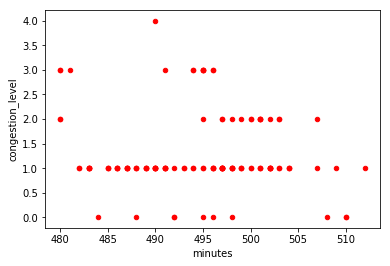

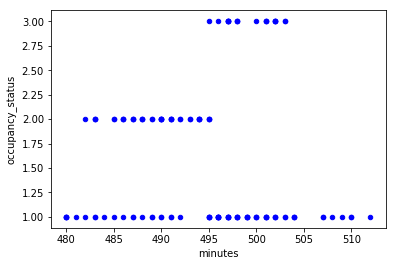

,id,stop_id,arrival_timestamp,vehicle_id,congestion_level,longitude,latitude,trip_id,occupancy_status,route_id,delay,timestamp,bus_timestamp,minutes,time,day
15625,15626,203220,1526025626,11954_76641264_2441_393_1,2,151.226517,-33.920284,647190,1,2441_393,-34,1526025623,2018-05-11 08:00:23,480,08:00:23,Fri
15626,15627,203573,1526025660,11954_76643179_2438_M10_1,0,151.239166,-33.941799,681398,1,2438_M10,0,1526025631,2018-05-11 08:00:31,480,08:00:31,Fri
15627,15628,203573,1526025675,11954_142497354_2441_393_1,0,151.238861,-33.940434,635971,1,2441_393,255,1526025636,2018-05-11 08:00:36,480,08:00:36,Fri
15628,15629,201082,1526025671,11954_76641088_2441_395_1,3,151.208099,-33.886047,607274,3,2441_395,851,1526025635,2018-05-11 08:00:35,480,08:00:35,Fri
15629,15630,203327,1526025654,11954_142495305_2441_393_1,4,151.223190,-33.911366,647188,3,2441_393,-126,1526025636,2018-05-11 08:00:36,480,08:00:36,Fri
15630,15631,203612,1526025644,11954_76641009_2441_391_1,0,151.230499,-33.956322,607825,1,2441_391,-556,1526025635,2018-05-11 08:00:35,480,08:00:35,Fri
15631,15632,2035130,1526025687,11954_76641087_2441_395_1,1,151.239502,-33.941124,607273,1,2441_395,-33,1526025631,2018-05-11 08:00:31,480,08:00:31,Fri
15632,15633,203574,1526025720,11954_76643179_2438_M10_1,0,151.239075,-33.941364,681398,1,2438_M10,0,1526025669,2018-05-11 08:01:09,481,08:01:09,Fri
15633,15634,203346,1526025701,11954_76640948_2441_395_1,1,151.225586,-33.915409,636024,1,2441_395,281,1526025661,2018-05-11 08:01:01,481,08:01:01,Fri
15634,15635,203574,1526025672,11954_142497354_2441_393_1,0,151.238129,-33.937325,635971,1,2441_393,252,1526025673,2018-05-11 08:01:13,481,08:01:13,Fri


In [25]:
import pandas as pd
import io
import datetime
import matplotlib.pyplot as plt


def get_time_of_day(ts):
    ts = datetime.datetime.fromtimestamp(ts)
    time_of_day = ts.strftime("%H:%M:%S")
    return time_of_day

weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

column_names = ["id",
                "stop_id",
                "arrival_timestamp",
                "vehicle_id",
                "congestion_level",
                "longitude","latitude",
                "trip_id",
                "occupancy_status",
                "route_id",
                "delay",
                "timestamp"]
df = pd.read_csv('./bus_updates.csv',
                 header = None, 
                 #nrows = 20000,
                 names = column_names)
#df["time_of_day"] = df['timestamp'].apply(get_time_of_day)
df["bus_timestamp"] = pd.to_datetime(df['timestamp'], unit='s')
df['minutes'] = df.bus_timestamp.dt.hour * 60 + df.bus_timestamp.dt.minute
df['time'] = df.bus_timestamp.dt.time
df['day'] = df['bus_timestamp'].dt.weekday
df['day'] = df.day.apply(lambda x: weekdays[x])
# Morning trips
df = df.loc[(df.bus_timestamp.dt.hour >= 8) & (df.bus_timestamp.dt.hour <= 21)] 
# Avoid weekends
#df = df.loc[(df.bus_timestamp.dt.weekday != 5) & (df.bus_timestamp.dt.weekday != 6)]

trip_df = df.loc[df['trip_id'] == '647190']

#trip_df = df.loc[(df['stop_id'] == 201056) & (df['route_id'] == '2438_M10')]# & (df['trip_id'].isin(['681261',
                                                                                         

trip_df.plot.scatter(x='minutes', y='congestion_level', color='red')
trip_df.plot.scatter(x='minutes', y='occupancy_status', color='blue')
#plt.plot(trip_df.minutes, trip_df.congestion_level, 'r-', label="Congestion Level")
#plt.plot(trip_df.minutes, trip_df.occupancy_status, 'b-', label="Seat Occupancy")
plt.show()

'''print(df.loc[(df['stop_id'] == 203320) & (df['route_id'] == '2441_393')].vehicle_id.unique())
df.loc[(df['stop_id'] == 201056) & (df['route_id'] == '2438_M10') & (df['trip_id'].isin(['681261',
                                                                                         '681263',
                                                                                         '681264',
                                                                                         '681265',
                                                                                         '681269',
                                                                                         '681270',
                                                                                         '681271',
                                                                                         '681273',
                                                                                         '681274', 
                                                                                         '681275']))]'''
df


